In [111]:
import cv2
from imutils import face_utils
import pandas as pd
import numpy as np
import mediapipe as mp

import os
import re
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt


Подготовка набора отклонений ключевых точек лица по 3-м признакам: внутренняя линия рта, изгиб бровей, форма челюсти

pack_identify - содержит наборы номеров точек по mediapipe для определения отклонения

In [164]:
pack_identify = {
    "mouth_up_all" : [61, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 291],
    "mouth_up_indicate" : [61, 78, 308, 291],
    "mouth_near_ext" : [95, 324],
    "mouth_left_ext" : 61,
    "mouth_rigth_ext" : 291,

    "left_brow" : [70, 63, 105, 66, 107, 55, 65],
    "rigth_brow" : [336, 296, 334, 293, 300, 285, 295],
    "left_brow_indicate" : [70, 107],
    "left_brow_center" : 105,
    "rigth_brow_indicate" : [336, 300],
    "rigth_brow_center" : 334,


    "jawline_all" : [234, 93, 132, 58, 172, 136, 150, 149, 176, 148, 152, 377, 400, 378, 379, 365, 397],
    "jawline_indicate" : [149, 176, 148, 152, 377, 400, 378],
    "jawline_center" : [148, 152, 377],
    "jawline_indicate" : [149, 378]
}

In [165]:
class Landmark():
    def __init__(self, x : int, y : int):
        self.x = x
        self.y = y

In [166]:
def segment_length(x1, y1, x2, y2):
    return math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)


def point_to_line_distance(x0, y0, x1, y1, x2, y2):
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = segment_length(x1, y1, x2, y2)
    if denominator == 0:
        raise ValueError("Точки x1,y1 и x2,y2 совпадают — нельзя построить прямую.")
    return numerator / denominator, denominator / 2

def safe_relative_deviation(height, base, max_ratio=10.0):
    if base == 0:
        return max_ratio
    ratio = height / base
    return min(ratio, max_ratio)  # защита от взрыва метрики



Отклонение считается через построение прямоугольного треугольника и деления длины противолежащего катета на длину прилежащего катета  
  
dev_mouth - Возвращает среднее отклонение крайних точек рта от основной линии  
dev-brows - Возвращает среднее отклонение центральных точек бровей от прямых, проходящих через крайние точки бровей  
dev-jawline - Возвращает среднее отклонение крайних точек нижней челюсти от прямой, описывающей нижний контур подбородка  

In [167]:
def dev_mouth(landmarks : list[Landmark],
              left_ext_idx : int = 61,
              rigth_ext_idx : int = 291,
              near_lms : list = pack_identify["mouth_near_ext"]):
    left_ext_lm = landmarks[left_ext_idx]
    rigth_ext_lm = landmarks[rigth_ext_idx]

    left_near_lm = landmarks[near_lms[0]]
    rigth_near_lm = landmarks[near_lms[1]]
    
    left_div_y = abs(left_ext_lm.y - left_near_lm.y)
    rigth_div_y = abs(rigth_ext_lm.y - rigth_near_lm.y)

    left_div_x = abs(left_ext_lm.x - left_near_lm.x)
    rigth_div_x = abs(left_ext_lm.x - left_near_lm.x)

    result_div = (safe_relative_deviation(left_div_y, left_div_x, 5) + safe_relative_deviation(rigth_div_y, rigth_div_x, 5)) / 2 * 100
    return result_div

def dev_brows(landmarks : list[Landmark],
                left_ext_idxs : list = pack_identify["left_brow_indicate"],
                rigth_ext_idxs : list = pack_identify["rigth_brow_indicate"],
                left_center_idx : int = pack_identify["left_brow_center"],
                rigth_center_idx : int = pack_identify["rigth_brow_center"]):
    left_dist, left_half_base_len = point_to_line_distance(landmarks[left_center_idx].x,
                                       landmarks[left_center_idx].y,
                                       landmarks[left_ext_idxs[0]].x,
                                       landmarks[left_ext_idxs[0]].y,
                                       landmarks[left_ext_idxs[1]].x,
                                       landmarks[left_ext_idxs[1]].y)
    
    rigth_dist, rigth_half_base_len = point_to_line_distance(landmarks[rigth_center_idx].x,
                                       landmarks[rigth_center_idx].y,
                                       landmarks[rigth_ext_idxs[0]].x,
                                       landmarks[rigth_ext_idxs[0]].y,
                                       landmarks[rigth_ext_idxs[1]].x,
                                       landmarks[rigth_ext_idxs[1]].y)

    result_div = (safe_relative_deviation(left_dist, left_half_base_len, 1) + safe_relative_deviation(rigth_dist, rigth_half_base_len, 1)) / 2 * 100
    
    return result_div

def dev_jawline(landmarks : list[Landmark],
                center : list[int] = pack_identify["jawline_center"],
                ext_idx : list[int] = pack_identify["jawline_indicate"]):
    left_dist, _ = point_to_line_distance(landmarks[ext_idx[0]].x,
                                       landmarks[ext_idx[0]].y,
                                       landmarks[center[0]].x,
                                       landmarks[center[0]].y,
                                       landmarks[center[-1]].x,
                                       landmarks[center[-1]].y)
    
    rigth_dist, _ = point_to_line_distance(landmarks[ext_idx[-1]].x,
                                       landmarks[ext_idx[-1]].y,
                                       landmarks[center[0]].x,
                                       landmarks[center[0]].y,
                                       landmarks[center[-1]].x,
                                       landmarks[center[-1]].y)
    
    left_dist_x = abs(landmarks[center[0]].x - landmarks[ext_idx[0]].x)
    rigth_dist_x = abs(landmarks[center[-1]].x - landmarks[ext_idx[-1]].x)

    result_div = (safe_relative_deviation(left_dist, left_dist_x, 3) + safe_relative_deviation(rigth_dist, rigth_dist_x, 3)) / 2 * 100

    return result_div
   


In [168]:
DATASET_ALL_DATA = "../all_data/"

# Загружаем модель
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)



In [169]:
def numeric_key(name):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', name)]

get_landmark - Возвращает список ключевых координат точек одной фотографии в относительных величинах (от 0 до 1)

In [ ]:
def get_landmarks(image_path):
    image_array = np.fromfile(image_path, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("Изображение не загружено!")
            
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Детектируем лицо
    faces = face_mesh.process(image_rgb)

    if not faces.multi_face_landmarks:
        return

    shape = faces.multi_face_landmarks[0]

    return [Landmark(p.x, p.y) for p in shape.landmark]

In [ ]:
all_devs = []
mouth_devs = []
brows_devs = []
jawline_devs = []
all_labels = []

t_procents_mouth = []
f_procents_mouth = []
t_procents_brows = []
f_procents_brows = []
t_procents_jawline = []
f_procents_jawline = []

build_dataframe - Обходит весь датасет фотографий и собирает набор отклонений для каждого признака

In [ ]:
def build_dataframe(dataset_dir,
                    t_procents_mouth: list,
                    f_procents_mouth: list,
                    t_procents_brows: list,
                    f_procents_brows: list,
                    t_procents_jawline: list,
                    f_procents_jawline: list,
                    get_label_func = lambda k : k // 8): # получаем числовой код папки
    k = 0
    for label_dir in sorted(os.listdir(dataset_dir), key=numeric_key):
        label_path = os.path.join(dataset_dir, label_dir)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_path, filename)
                result = get_landmarks(image_path)
                if result is None:
                    continue
                landmarks = result
                
                avg_dev_percent_mouth = dev_mouth(
                    landmarks = landmarks)
                avg_dev_percent_brows = dev_brows(
                    landmarks = landmarks)
                avg_dev_percent_jawline = dev_jawline(
                    landmarks = landmarks)
                
                label = get_label_func(k) % 2
                if label == 0:
                    t_procents_mouth.append(avg_dev_percent_mouth)
                    t_procents_brows.append(avg_dev_percent_brows)
                    t_procents_jawline.append(avg_dev_percent_jawline)

                else:
                    f_procents_mouth.append(avg_dev_percent_mouth)
                    f_procents_brows.append(avg_dev_percent_brows)
                    f_procents_jawline.append(avg_dev_percent_jawline)

                all_devs.append(np.array([avg_dev_percent_mouth, avg_dev_percent_brows, avg_dev_percent_jawline]))
                mouth_devs.append(avg_dev_percent_mouth)
                brows_devs.append(avg_dev_percent_brows)
                jawline_devs.append(avg_dev_percent_jawline)
                all_labels.append(label)
                
        k += 1


In [174]:
build_dataframe(DATASET_ALL_DATA,
                t_procents_mouth=t_procents_mouth,
                f_procents_mouth=f_procents_mouth,
                t_procents_brows=t_procents_brows,
                f_procents_brows=f_procents_brows,
                t_procents_jawline=t_procents_jawline,
                f_procents_jawline=f_procents_jawline,)


In [176]:
print(f"Среднее отклонение линии рта для thinking: {sum(t_procents_mouth)/len(t_procents_mouth):.2f}%")

print(f"Среднее отклонение линии рта для feeling: {sum(f_procents_mouth)/len(f_procents_mouth):.2f}%")

Среднее отклонение линии рта для thinking: 22.03%
Среднее отклонение линии рта для feeling: 19.91%


In [177]:
print(f"Среднее отклонение челюсти для thinking: {sum(t_procents_jawline)/len(t_procents_jawline):.2f}%")

print(f"Среднее отклонение челюсти для feeling: {sum(f_procents_jawline)/len(f_procents_jawline):.2f}%")

Среднее отклонение челюсти для thinking: 59.11%
Среднее отклонение челюсти для feeling: 55.75%


In [178]:
print(f"Среднее отклонение бровей для thinking: {sum(t_procents_brows)/len(t_procents_brows):.2f}%")

print(f"Среднее отклонение бровей для feeling: {sum(f_procents_brows)/len(f_procents_brows):.2f}%")

Среднее отклонение бровей для thinking: 28.91%
Среднее отклонение бровей для feeling: 28.93%


create_dataframe - СОздает pandas Dataframe из набора отклонений признаков + метки для кажой записи соответсвенно

In [179]:
def create_dataframe(sequence, columns):
    df = pd.DataFrame(sequence, columns=columns)
    df['label'] = all_labels
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
columns = ["dev_mouth", "dev_brows", "dev_jawline"]

df_all = create_dataframe(all_devs, columns=columns)

In [184]:
def print_analitics(df : pd.DataFrame, fitcha):
    plt.plot(df[f'{fitcha}'])  # или другая колонка
    plt.title(f'Отклонение показательных точек {fitcha}')
    plt.xlabel('Индекс')
    plt.ylabel('Значение (%)')
    plt.grid(True)
    plt.show()

    df_0 = df[df["label"] == 0][f"{fitcha}"]
    df_1 = df[df["label"] == 1][f"{fitcha}"]

    plt.scatter(df_0.index, df_0, color='blue', label='Label 0', alpha=0.5)
    plt.scatter(df_1.index, df_1, color='red', label='Label 1', alpha=0.5)

    plt.title(f"Значения {fitcha}, разделенные по метке")
    plt.xlabel("Индекс")
    plt.ylabel(f"{fitcha}")
    plt.legend()
    plt.show()

    sns.stripplot(data=df, x="label", y=f"{fitcha}", palette="Set1", jitter=True, alpha=0.5)
    plt.title(f"{fitcha} по меткам")
    plt.show()

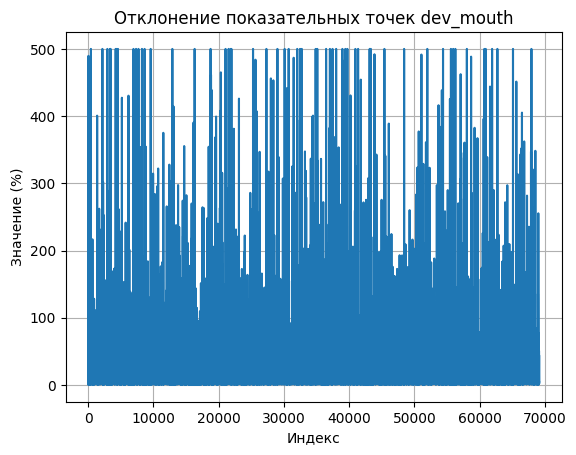

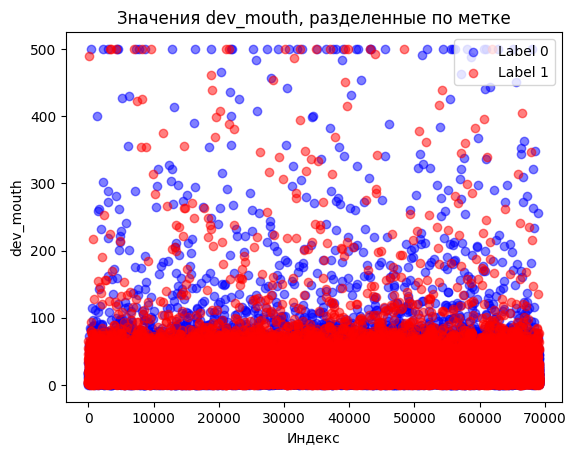

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_15436\690428153.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="label", y=f"{fitcha}", palette="Set1", jitter=True, alpha=0.5)


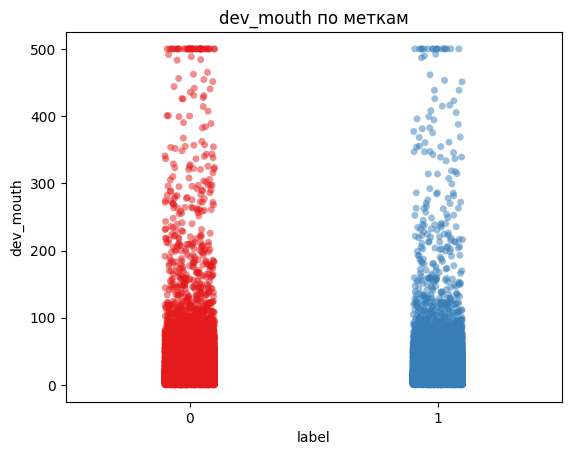

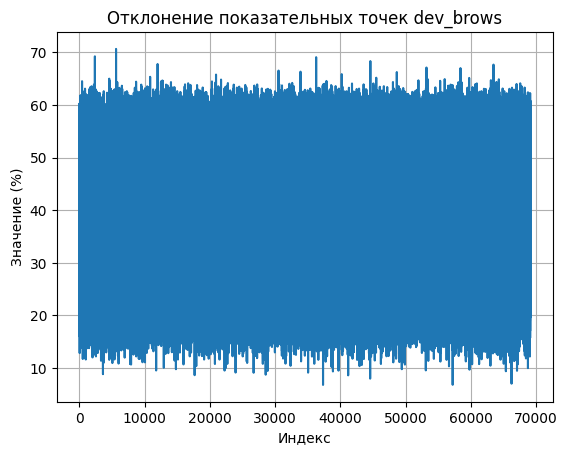

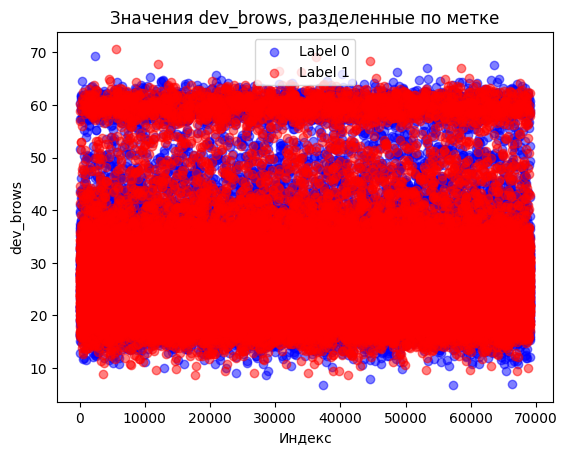

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_15436\690428153.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="label", y=f"{fitcha}", palette="Set1", jitter=True, alpha=0.5)


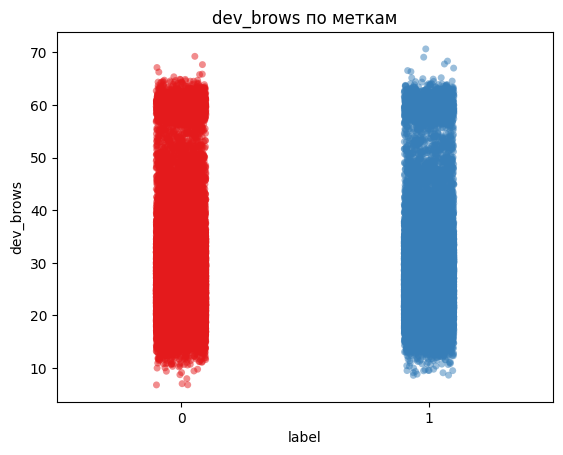

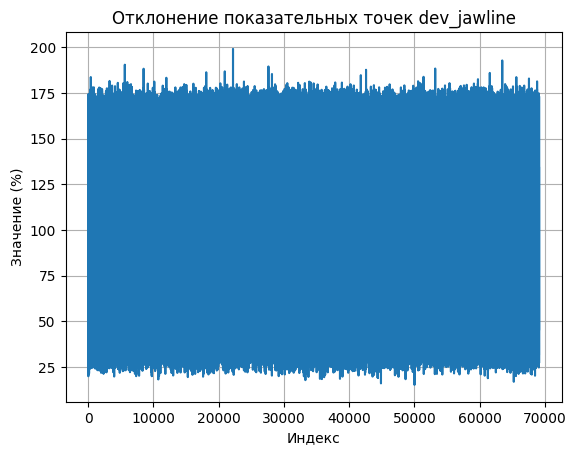

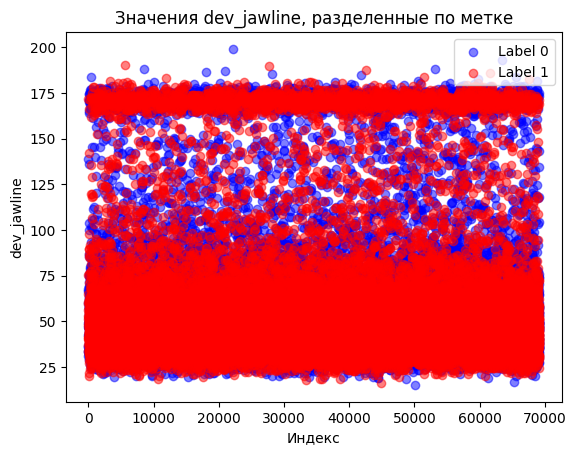

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_15436\690428153.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="label", y=f"{fitcha}", palette="Set1", jitter=True, alpha=0.5)


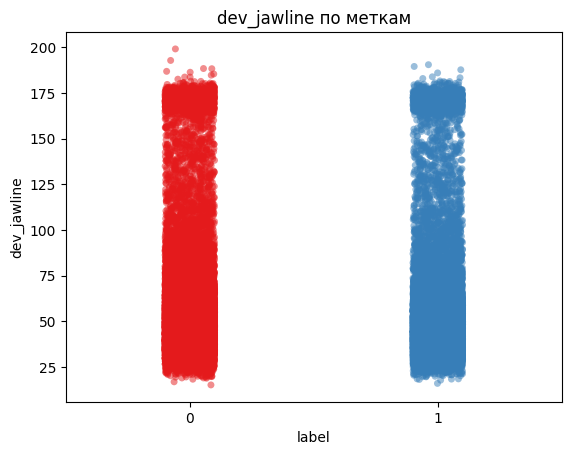

In [185]:
print_analitics(df_all, "dev_mouth")
print_analitics(df_all, "dev_brows")
print_analitics(df_all, "dev_jawline")



Ниже блоки для работы с моделью логистической регрессии

agg_train_test_split - Разделение датафрейма на тренировочную и тестовую выборки,  
create_model - Создание и обучение модели логистичесской регрессии.

In [192]:
def agg_train_test_split(df : pd.DataFrame):
    return train_test_split(
    df.drop(columns=['label']),  # все колонки кроме 'label'
    df['label'],                 # сами метки
    test_size=0.2,                # 20% на тест
    stratify=df_all['label'],         # сбалансированная разбивка по классам
    random_state=42
)

def create_model(x_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model

In [ ]:
#Разделим данные
X_train_all, X_test_all, y_train_all, y_test_all = agg_train_test_split(df_all)

X_train_mouth, X_test_mouth, y_train_mouth, y_test_mouth = agg_train_test_split(df_mouth)

X_train_brows, X_test_brows, y_train_brows, y_test_brows = agg_train_test_split(df_brows)

X_train_jawline, X_test_jawline, y_train_jawline, y_test_jawline = agg_train_test_split(df_jawline)


#Обучим модель
model_all = create_model(X_train_all, y_train_all)

model_mouth = create_model(X_train_mouth, y_train_mouth)

model_brows = create_model(X_train_brows, y_train_brows)

model_jawline = create_model(X_train_jawline, y_train_jawline)

#Предсказание
y_pred_all = model_all.predict(X_test_all)
y_pred_mouth = model_mouth.predict(X_test_mouth)
y_pred_brows = model_brows.predict(X_test_brows)
y_pred_jawline = model_jawline.predict(X_test_jawline)



Accuracy binary class for all signs: 0.5562
Accuracy binary class for mouth: 0.5448
Accuracy binary class for brows: 0.5408
Accuracy binary class for jawline: 0.5397


Вывод точности предсказания модели меток на тестовой выборке

In [196]:
print(f"Accuracy binary class for all signs: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"Accuracy binary class for mouth: {accuracy_score(y_test_mouth, y_pred_mouth):.4f}")
print(f"Accuracy binary class for brows: {accuracy_score(y_test_brows, y_pred_brows):.4f}")
print(f"Accuracy binary class for jawline: {accuracy_score(y_test_jawline, y_pred_jawline):.4f}")

Accuracy binary class for all signs: 0.5562
Accuracy binary class for mouth: 0.5448
Accuracy binary class for brows: 0.5408
Accuracy binary class for jawline: 0.5397


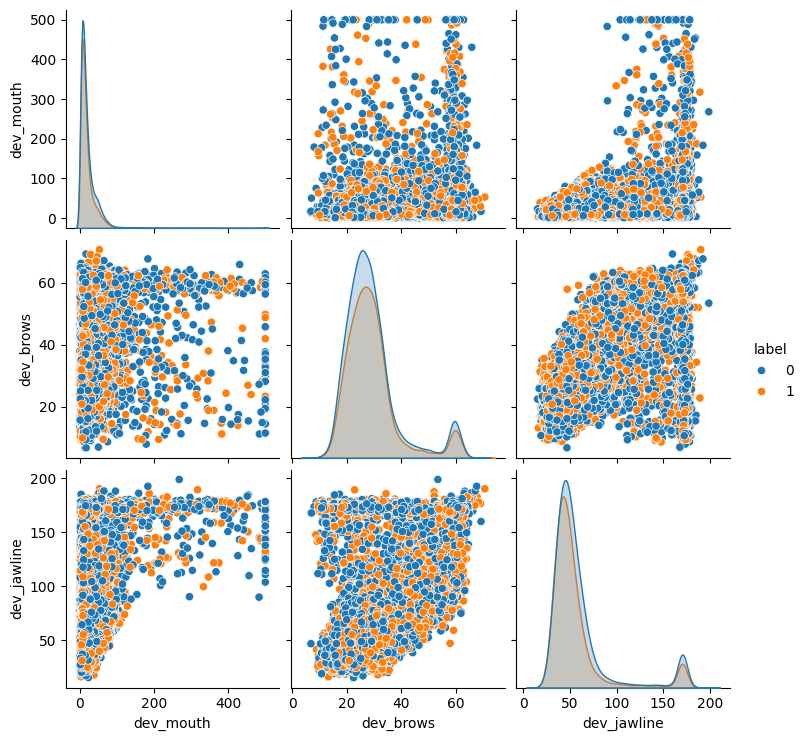

In [195]:
sns.pairplot(df_all, hue='label')